In [24]:
!rm -rf snake_species_images

In [ ]:
pip install requests beautifulsoup4 pillow

In [25]:
import requests
from bs4 import BeautifulSoup
import os
import time

def download_images(base_url, folder_name, num_images=100, delay=1):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    total_downloaded = 0
    page = 1

    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    while total_downloaded < num_images:
        response = requests.get(base_url, headers=headers)
        if response.status_code != 200:
            print(f"Failed to retrieve page {page}")
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        images = soup.find_all('img')

        for img in images:
            if total_downloaded >= num_images:
                break

            img_url = img.get('src')
            if not img_url:
                continue
            if not img_url.startswith('http'):
                img_url = 'https:' + img_url

            try:
                img_data = requests.get(img_url, headers=headers).content
                extension = img_url.split('.')[-1]
                with open(f"{folder_name}/img_{total_downloaded}.{extension}", 'wb') as handler:
                    handler.write(img_data)
                total_downloaded += 1
                print(f"Downloaded {total_downloaded}/{num_images}")
            except Exception as e:
                print(f"Failed to download {img_url}: {e}")

        page += 1
        time.sleep(delay)  # Respect the website's rate limit

    print(f"Finished downloading {total_downloaded} images.")

# Example usage for different snake species
species_urls = {
    'python': 'https://www.flickr.com/search/?text=python+snake',
    'cobra': 'https://www.flickr.com/search/?text=cobra+snake',
    'viper': 'https://www.flickr.com/search/?text=viper+snake',
    'rattlesnake': 'https://www.flickr.com/search/?text=rattlesnake',
    'boa': 'https://www.flickr.com/search/?text=boa+snake',
    'king': 'https://www.flickr.com/search/?text=king+snake',
    'coral': 'https://www.flickr.com/search/?text=coral+snake',
    'mamba': 'https://www.flickr.com/search/?text=mamba+snake',
    'sea': 'https://www.flickr.com/search/?text=sea+snake',
    'anaconda': 'https://www.flickr.com/search/?text=anaconda+snake'
}

for species, url in species_urls.items():
    download_images(url, f'{species}_images', num_images=1000)

Streaming output truncated to the last 5000 lines.
Downloaded 6/1000
Downloaded 7/1000
Downloaded 8/1000
Downloaded 9/1000
Downloaded 10/1000
Downloaded 11/1000
Downloaded 12/1000
Downloaded 13/1000
Downloaded 14/1000
Downloaded 15/1000
Downloaded 16/1000
Downloaded 17/1000
Downloaded 18/1000
Downloaded 19/1000
Downloaded 20/1000
Downloaded 21/1000
Downloaded 22/1000
Downloaded 23/1000
Downloaded 24/1000
Downloaded 25/1000
Downloaded 26/1000
Downloaded 27/1000
Downloaded 28/1000
Downloaded 29/1000
Downloaded 30/1000
Downloaded 31/1000
Downloaded 32/1000
Downloaded 33/1000
Downloaded 34/1000
Downloaded 35/1000
Downloaded 36/1000
Downloaded 37/1000
Downloaded 38/1000
Downloaded 39/1000
Downloaded 40/1000
Downloaded 41/1000
Downloaded 42/1000
Downloaded 43/1000
Downloaded 44/1000
Downloaded 45/1000
Downloaded 46/1000
Downloaded 47/1000
Downloaded 48/1000
Downloaded 49/1000
Downloaded 50/1000
Downloaded 51/1000
Downloaded 52/1000
Downloaded 53/1000
Downloaded 54/1000
Downloaded 55/1000
Dow

In [2]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    if image is None:  # Check if image loaded successfully
        print(f"Failed to load image: {image_path}")
        return None
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def image_data_generator(file_paths, labels, batch_size, target_size=(224, 224)):
    num_samples = len(file_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = file_paths[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            images = [load_and_preprocess_image(path, target_size) for path in batch_paths]
            images = np.array(images)

            yield images, np.array(batch_labels)

# Define paths
data_dir = 'snake_species_images'
categories = ["anaconda_images", "boa_images", "cobra_images", "coral_images", "king_images", "mamba_images", "python_images", "rattlesnake_images", "sea_images", "viper_images"]

# Prepare dataset
file_paths = []
labels = []

for category in categories:
    class_path = os.path.join(data_dir, category)
    class_index = categories.index(category)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        file_paths.append(img_path)
        labels.append(class_index)

# Convert to numpy arrays for shuffling and splitting
file_paths = np.array(file_paths)
labels = np.array(labels)

# Split data
X_train_paths, X_temp_paths, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.3, random_state=42)
X_val_paths, X_test_paths, y_val, y_test = train_test_split(X_temp_paths, y_temp, test_size=0.5, random_state=42)

# Data generators
batch_size = 32
train_generator = image_data_generator(X_train_paths, y_train, batch_size)
val_generator = image_data_generator(X_val_paths, y_val, batch_size)

# Determine the number of steps per epoch
steps_per_epoch = len(X_train_paths) // batch_size
validation_steps = len(X_val_paths) // batch_size

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gc

def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

num_classes = len(categories)

base_models = [ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
               DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
               MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))]

models = [create_model(base_model, num_classes) for base_model in base_models]

In [4]:
results = []
epochs = 50

for model in models:
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_generator, validation_steps=validation_steps,
                        callbacks=[early_stopping, checkpoint])

    results.append(history.history)

    # Clear memory after each model training
    tf.keras.backend.clear_session()
    gc.collect()

print("Training complete for all models.")

Epoch 1/50
218/218 [==============================] - ETA: 0s - loss: 0.8612 - accuracy: 0.7532

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


218/218 [==============================] - 85s 218ms/step - loss: 0.8612 - accuracy: 0.7532 - val_loss: 12.6978 - val_accuracy: 0.0876
Epoch 2/50
218/218 [==============================] - 49s 209ms/step - loss: 0.1672 - accuracy: 0.9528 - val_loss: 4.6603 - val_accuracy: 0.1053
Epoch 3/50
218/218 [==============================] - 44s 203ms/step - loss: 0.0401 - accuracy: 0.9882 - val_loss: 5.8530 - val_accuracy: 0.0910
Epoch 4/50
218/218 [==============================] - 46s 210ms/step - loss: 0.0410 - accuracy: 0.9881 - val_loss: 1.0626 - val_accuracy: 0.6746
Epoch 5/50
218/218 [==============================] - 45s 209ms/step - loss: 0.0809 - accuracy: 0.9785 - val_loss: 0.6977 - val_accuracy: 0.8995
Epoch 6/50
218/218 [==============================] - 44s 203ms/step - loss: 0.0699 - accuracy: 0.9809 - val_loss: 3.1086 - val_accuracy: 0.5666
Epoch 7/50
218/218 [==============================] - 45s 208ms/step - loss: 0.0385 - accuracy: 0.9881 - val_loss: 0.0853 - val_accuracy: 0.

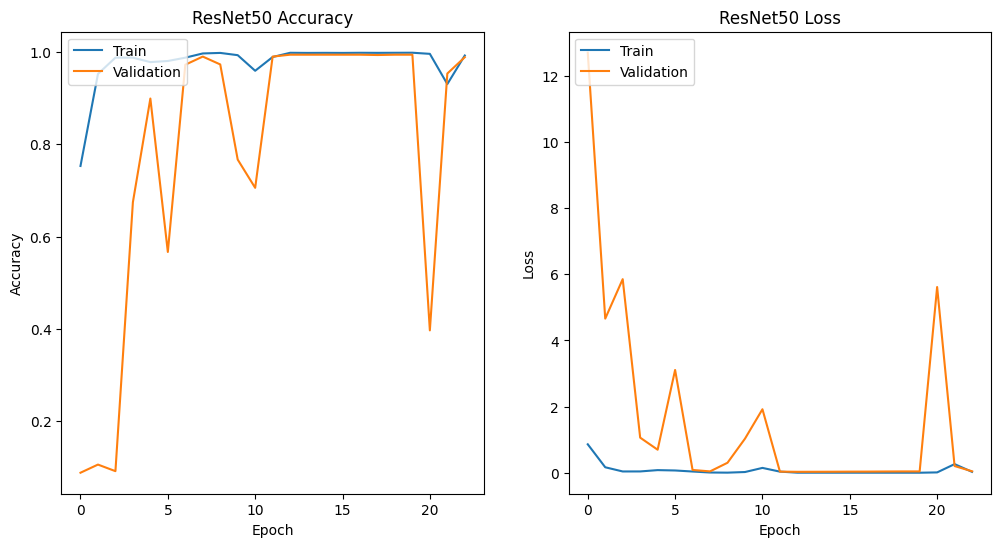

47/47 [==============================] - 2s 50ms/step


<Figure size 2000x1600 with 0 Axes>

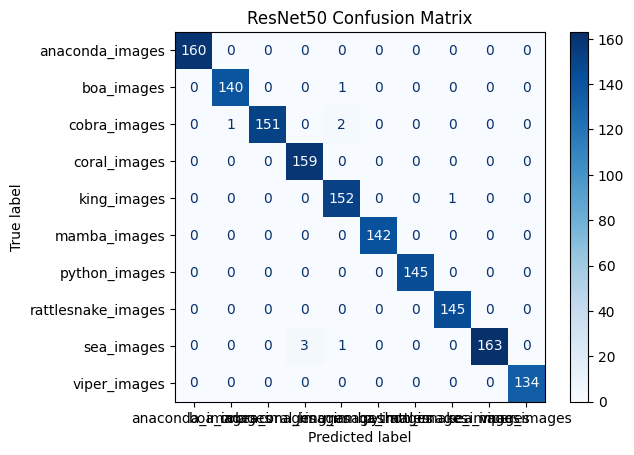

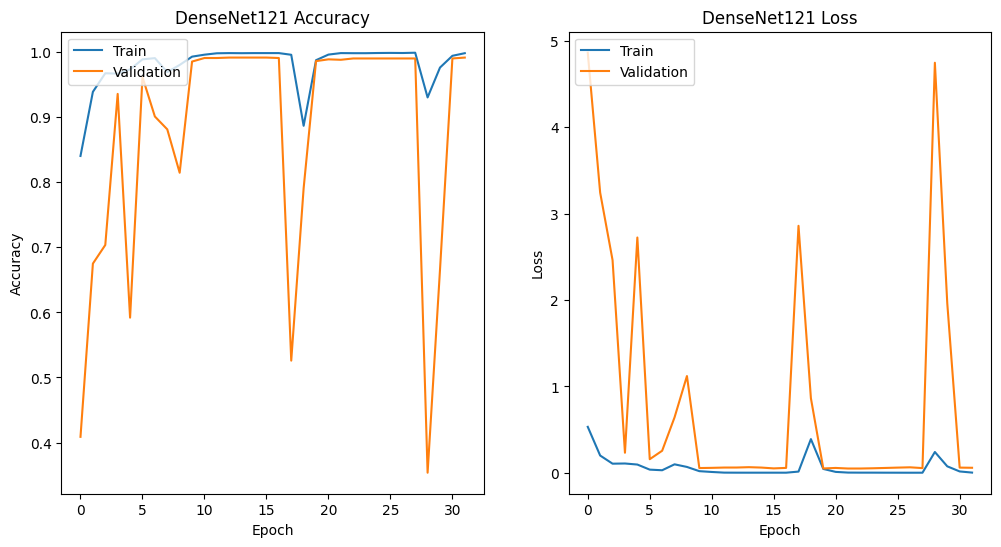

47/47 [==============================] - 2s 51ms/step


<Figure size 2000x1600 with 0 Axes>

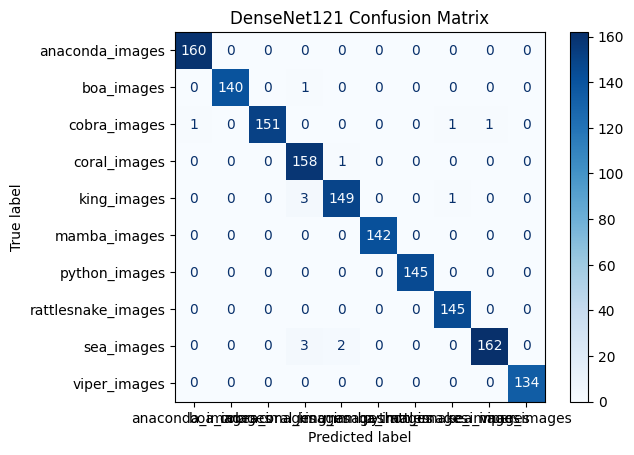

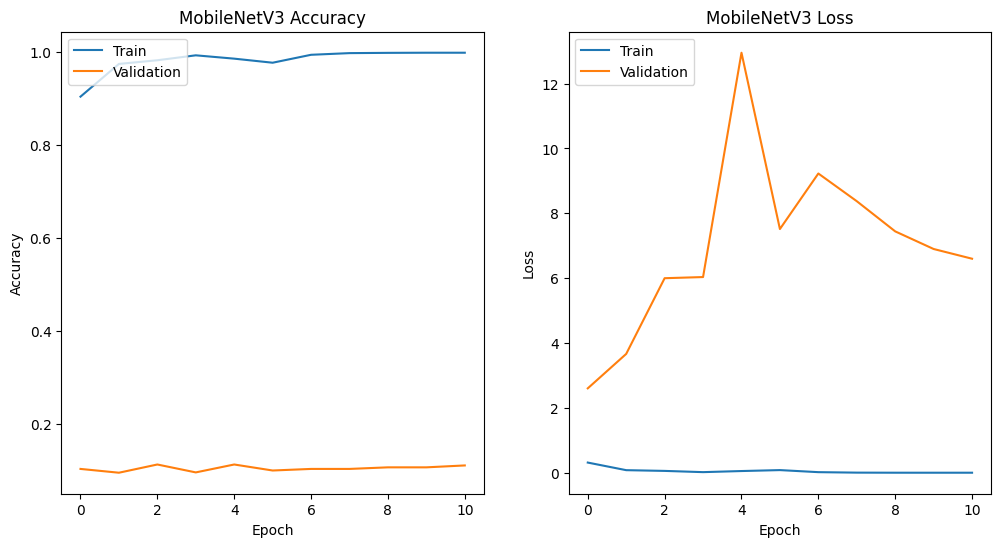

47/47 [==============================] - 1s 10ms/step


<Figure size 2000x1600 with 0 Axes>

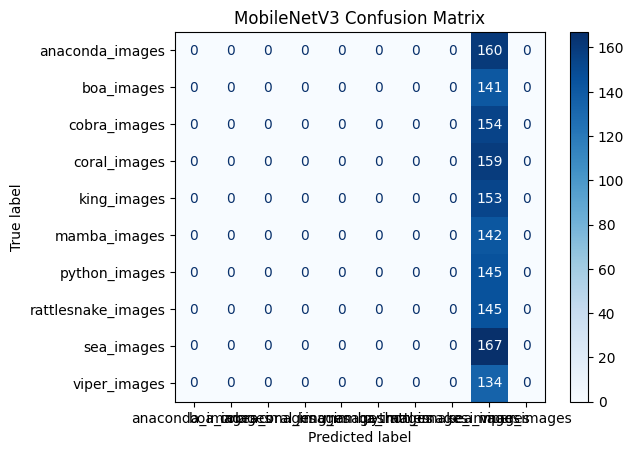

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy']) # Access the 'accuracy' key directly from the dictionary
    plt.plot(history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

def plot_confusion_matrix(model, X_test_paths, y_test, model_name): # Added X_test_paths as input
    # Load and preprocess images from paths
    X_test = np.array([load_and_preprocess_image(path) for path in X_test_paths])

    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(20, 16))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

model_names = ['ResNet50', 'DenseNet121', 'MobileNetV3']
for i, model in enumerate(models):
    plot_history(results[i], model_names[i]) # Pass the dictionary directly
    plot_confusion_matrix(model, X_test_paths, y_test, model_names[i]) # Pass X_test_paths to the function

In [9]:
def evaluate_model(model, X_test_paths, y_test): # Changed X_test to X_test_paths
    X_test = np.array([load_and_preprocess_image(path) for path in X_test_paths]) # Load images
    results = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {results[0]}")
    print(f"Test Accuracy: {results[1]}")

for i, model in enumerate(models):
    print(f'Evaluating {model_names[i]}...')
    evaluate_model(model, X_test_paths, y_test) # Pass X_test_paths to the function

Evaluating ResNet50...
Test Loss: 0.021747615188360214
Test Accuracy: 0.9940000176429749
Evaluating DenseNet121...
Test Loss: 0.04727533087134361
Test Accuracy: 0.9906666874885559
Evaluating MobileNetV3...
Test Loss: 2.5877633094787598
Test Accuracy: 0.11133333295583725


In [12]:
from sklearn.metrics import average_precision_score

def calculate_map(model, X_test_paths, y_test, num_classes): # Add num_classes as a parameter
    X_test = np.array([load_and_preprocess_image(path) for path in X_test_paths])
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    y_true_one_hot = np.eye(num_classes)[y_test]
    y_pred_one_hot = np.eye(num_classes)[y_pred]

    ap_list = []
    for i in range(num_classes):
        ap = average_precision_score(y_true_one_hot[:, i], y_pred_one_hot[:, i])
        ap_list.append(ap)

    return np.mean(ap_list)

# Calculate mAP for each model
for i, model in enumerate(models):
    mAP = calculate_map(model, X_test_paths, y_test, num_classes) # Pass num_classes to the function
    results[i]['mAP'] = mAP # Store mAP in the results dictionary
    print(f"{model_names[i]} - mAP: {mAP:.4f}")

47/47 [==============================] - 2s 50ms/step
ResNet50 - mAP: 0.9891
47/47 [==============================] - 2s 51ms/step
DenseNet121 - mAP: 0.9833
47/47 [==============================] - 0s 10ms/step
MobileNetV3 - mAP: 0.1000


# **Conclusion**
All 3 type modul have successfully run and able to show the result.<br><br>
Recommend modul: ResNet50<br>
Reason: The most highest accuracy by %99.4 while other is lower like for DenseNet121 is %99 and for MobileNetV3 is %11. Secondly is that it's the lowest loss among other modal. Lastly, based on mAP it show that ResNet50 is the highest compare to other.